## Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

The data: Protein quantity measurements of brain tissue samples from multiple regions.

Here we read in the data, store a feature for visualization later, and drop non-numeric features from the dataset.

In [44]:
filepath = "/home/ramya/my-workspace/src/feeding_study_cleanup/scripts/action_schema_data-small.csv"
data = pd.read_csv(filepath)
#print(data["Bag File Name"])

names = data["Bag File Name"]
names

# Drop the rows aren't skewered items. Using substrings due to naming
# inconsistencies (e.g., doughnutholes vs. donutholes)
skewered_item_substrings = [
    "chicken",
    "broc",
    "fri",
    "fry",
    "bagel",
    "nut",
    "lettuce",
    "spinach",
    "sand",
    "pizza",
]
rows_to_drop = []
for i, row in data.iterrows():
    is_skewered = False
    for substr in skewered_item_substrings:
        if substr in row["Bag File Name"]:
            is_skewered = True
            break
    if not is_skewered:
        rows_to_drop.append(i)
data  = data.drop(rows_to_drop, axis=0)
print(data["Bag File Name"])

# Drop the columns that aren't part of the action schema
data  = data.drop([
    "Save Timestamp",
    "Bag File Name",
    "Action Start Time",
    "Action Contact Time",
    "Action Extraction Time",
    "Action End Time",
    "Bag Duration",
    "Food Reference Frame Translation X",
    "Food Reference Frame Translation Y",
    "Food Reference Frame Translation Z",
    "Food Reference Frame Rotation X",
    "Food Reference Frame Rotation Y",
    "Food Reference Frame Rotation Z",
], axis=1)

#print(data)




0          1-sandwich-1_2021-11-23-14-00-49
1           1-spinach-4_2021-11-23-13-42-15
2             2-pizza-4_2021-11-23-15-19-49
3          2-sandwich-5_2021-11-23-15-08-52
4           3-lettuce-4_2021-11-23-18-04-06
8          5-broccoli-4_2021-11-24-09-58-50
9     6-doughnutholes-5_2021-11-24-12-42-28
12           7-bagels-1_2021-11-24-14-51-50
13            7-fries-5_2021-11-24-15-10-04
14         8-broccoli-5_2021-11-24-15-45-19
15          9-chicken-4_2021-11-24-16-40-03
Name: Bag File Name, dtype: object


The other columns indicate the amount of a protein present in that brain tissue sample.

## Pre-processing

Next, let's normalize the data using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

This is important because PCA picks the dimensions (linear combinations of the features) that **maximize variance**. We want this procedure to be agnostic to the units of the dataset. For example, let's say one column had units `km` and you then change it to `cm`. The variance of that column will now jump up 100x, and therefore PCA will put more weight on that column. This is undesirable because nothing has fundamentally changed amongst the dataset. To avoid this behavior, we normalize the data before inputting it into PCA.

In [45]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
clean_data = imp_mean.fit_transform(clean_data)
print(np.any(np.isnan(clean_data)))

False


In [46]:
clean_data = StandardScaler().fit_transform(data)
clean_data

array([[-7.41054134e-01, -9.12926840e-01,  1.57564866e-01,
        -2.10469140e+00,  7.80404521e-01, -2.57079136e-01,
        -3.23473759e-01, -9.64538598e-01, -4.98583401e-01,
         1.40125849e+00,  2.68817017e-01,  2.30307434e-01,
         2.28616830e-01,  3.97117412e-01, -1.29919206e+00,
         2.81122332e-01,  1.30063634e+00, -2.37270871e-01,
        -3.08999702e-01, -9.66382420e-01,  1.65885683e-01,
         1.72689186e-01,  1.42084723e-01, -4.75678280e-01,
         3.80248623e-01, -1.33623438e+00],
       [-1.37589130e+00, -7.47575139e-01,  1.53656487e+00,
        -4.96574396e-01, -1.43752414e+00, -1.86819687e-01,
         3.05943859e-01,  1.45442682e+00, -5.97644272e-01,
         8.73047095e-01,  2.55063508e-01,  2.30012671e-01,
         2.26566850e-01,  3.75276265e-01, -1.37203076e+00,
         3.07978712e-01,  1.36097606e+00,  1.72926763e-01,
        -2.77032092e-01,  5.72946187e-01, -7.52331991e-01,
         2.56364281e-01,  5.71444509e-02, -4.53653750e-01,
         6.53

##  PCA

Finally, we set-up our [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) model, fit it, and transform the data (embed it in low dimensional space)

In [60]:
pca = PCA(n_components=11)
pca.fit(data)
transformed = pca.transform(data)

We can see how much variance each PC explains. Select the first 5 components.

In [61]:
# Display the explained variance ratio of the first 5 PCs
print(pca.explained_variance_ratio_[0:5])
# What is the total ratio of the variance this explains?
print(pca.explained_variance_ratio_[0:5].sum())

[0.87667306 0.10272929 0.01239888 0.00448653 0.00152411]
0.997811871055624


**Question**: What ratio of the total variance would be explained by the first 29 components?

In [62]:
print(pca.explained_variance_ratio_[0:29].sum())

1.0


## Plots

Here we see that two main clusters are apparent in this low dimensional space

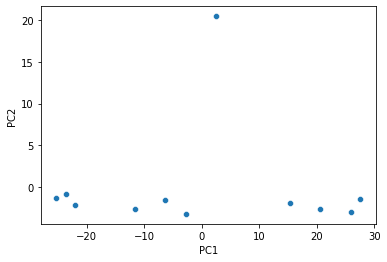

In [64]:
sns.scatterplot(x=transformed[:,0], y=transformed[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Question**: Did we just do clustering using PCA? Why or why not?

After coloring by brain region, we can see that the islands represent the difference between the hippocampus and other brain regions

In [65]:
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=names)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

ValueError: array length 11 does not match index length 16

**Question**: How can we interpret this result, in light of what our dataset represents?

We can look at other PCs as well. There are outliers that become apparent here!

In [59]:
sns.scatterplot(x=transformed[:,1], y=transformed[:,2], hue=names)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

ValueError: array length 11 does not match index length 16

**Question**: Why was PCA helpful for this problem (why did we use it)?